In [81]:
using Raytracing
using PyPlot
using FFTW

smoothe(A, x, y, σ) = real.(ifftshift(ifft(fft(A) .* fft(@. exp(-(x^2+y'^2)/σ^2)))))
;

In [82]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10
minval = 0.5
maxval = 1.0
cmap = get_cmap("PuOr")
violett = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
cmap = get_cmap("seismic")
red = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
;

In [83]:
U = 30e3

L = 50e-6
z = 0.5
w = 15e-6

# same as for the wave simulation for easier image comparison
Δx = 6.97e-9

x = Vector{Float64}(range(-L/2, L/2-Δx, step=Δx))
y = copy(x)

extent_e = [x[1], x[end], y[1], y[end]] .* 1e6
;

In [84]:
c = 299792458           # the speed of light
ħ = 1.054571817e-34     # the reduced planck constant
m_e = 9.1093837015e-31  # the electron mass
q = 1.602176634e-19     # electron charge
ε_0 = 8.8541878128e-12  # vacuum permitivity

v = c * sqrt(1 - 1 / (1 + q*U/m_e/c^2)^2)
α = 1 / (4 * π * ε_0) * q^2 / (ħ * c)
β = v / c
γ = 1 / sqrt(1 - β^2)
Ee = γ*m_e*c^2
;

In [85]:
FWHM = 4.3e-6
wgauss = FWHM / 2.355
#wgauss = 10e-6
gauss_sep = 6e-6

# phase difference
Δφ = 2*π/1

Δimg = 0.02e-6

ximg = Vector{Float64}(range(-8e-6, 8e-6, step=Δimg))
yimg = Vector{Float64}(range(-16e-6, 16e-6, step=Δimg))

λ_l = 1035e-9
E = 60e-9

N = sum(@. exp(-(ximg^2 + yimg'^2)/wgauss^2)) * Δimg^2
K = α * λ_l^2 / (2 * π * (1 + β) * Ee)

B = (1 - N * Δφ / K / E) / (1 + N * Δφ / K / E)

I = @. (exp(-ximg^2/2/wgauss^2 - (yimg'-gauss_sep/2)^2/2/wgauss^2 )
        + B * exp(-ximg^2/2/wgauss^2 - (yimg'+gauss_sep/2)^2/2/wgauss^2 ) )

norm = sum(I) * Δimg^2

extent_e = [x[1], x[end], y[1], y[end]].*1e6
ψ = smoothe([i^2 + j^2 < w^2 ? 1. : 0. for i in x, j in y], x, y, 1e-6)

eb = Electron(x, y, ψ, U, Int(10e6))
lf = LightField(I, norm, ximg, yimg, λ_l, E)

pond = PondInteraction(lf)
free = Free(z)

setup = Setup(pond, free)

propagation!(eb, setup)

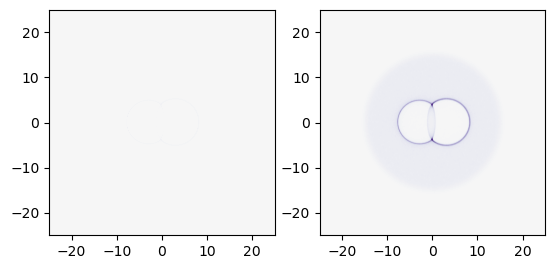

In [86]:
pygui(false)

out_int = getintensity(eb, x, y)
out_smeared = smoothe(out_int, x, y, 150e-9)

fig, (ax1, ax2) = subplots(1, 2)
ax1.imshow(out_int, cmap=violett, extent=extent_e)
ax2.imshow(out_smeared, cmap=violett, extent=extent_e)
;

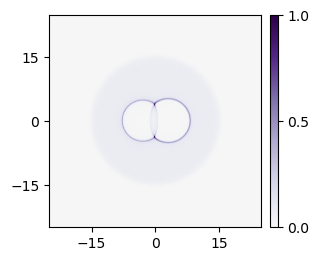

In [87]:
max_big = maximum(out_smeared)
out_plot = out_smeared ./ max_big
out_plot[1, 1] = 0

figsize = [7, 7] ./ 2.54

savestring = ("ray_gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"dphi"*string(round(Int, Δφ))*"_picture.svg")

pygui(false)
fig, ax = subplots(figsize=figsize)
plt = ax.imshow(out_plot, cmap=violett, extent=extent_e)

#ax.set_xlabel("µm")
#ax.set_ylabel("µm")

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)
savefig("./images/asym/"*savestring, bbox_inches="tight", dpi=300)
;

0.09334948642566751

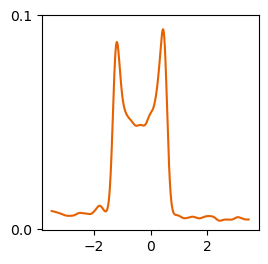

In [88]:
fov = 1000
cross = out_plot[round(Int, size(out_int, 1)/2),
            round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)]
xcross = x[round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)] .* 1e6

figsize = [7, 7] ./ 2.504

savestring = ("ray_diff_gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"dphi"*string(round(Int, Δφ))*"_cross.svg")

pygui(false)
fig, ax = subplots(figsize=figsize)
ax.plot(xcross, cross, color="#E66100")

ax.set_yticks([0, 0.1])
ax.set_xticks([-2, 0, 2])
cross_max_big = maximum(cross)
display(cross_max_big)
;

In [89]:
U = 30e3

L2 = 8e-6
z = 0.5
w = 15e-6

# same as for the wave simulation for easier image comparison
Δx = 6.97e-9

x2 = Vector{Float64}(range(-L2/2, L2/2-Δx, step=Δx))
y2 = copy(x2)

extent_e = [x2[1], x2[end], y2[1], y2[end]] .* 1e6

ψ = smoothe([i^2 + j^2 < w^2 ? 1. : 0. for i in x2, j in y2], x2, y2, 1e-6)

eb2 = Electron(x2, y2, ψ, U, Int(20e6))
lf = LightField(I, norm, ximg, yimg, λ_l, E)

pond = PondInteraction(lf)
free = Free(z)

setup = Setup(pond, free)

propagation!(eb2, setup)

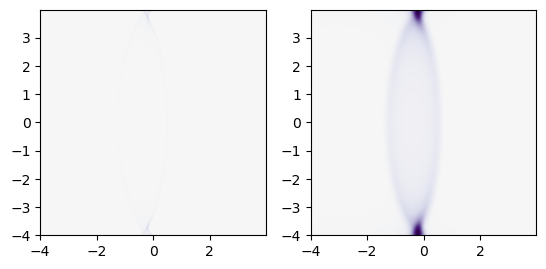

In [90]:
pygui(false)

out_int = getintensity(eb2, x2, y2)
out_smeared = smoothe(out_int, x2, y2, 150e-9)

fig, (ax1, ax2) = subplots(1, 2)
ax1.imshow(out_int, cmap=violett, extent=extent_e)
ax2.imshow(out_smeared, cmap=violett, extent=extent_e)
;

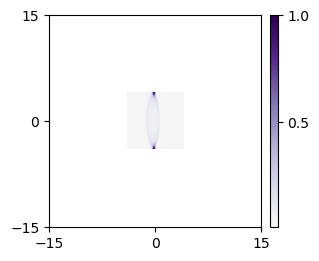

In [91]:
out_plot = out_smeared ./ maximum(out_smeared)

figsize = [7, 7] ./ 2.54

savestring = ("diff_ray_gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"E"*string(round(Int, E*1e9))*"_picture.svg")

pygui(false)
fig, ax = subplots(figsize=figsize)
plt = ax.imshow(out_plot, cmap=violett, extent=extent_e)

#ax.set_xlabel("µm")
#ax.set_ylabel("µm")

ax.set_xticks([-15, 0, 15])
ax.set_yticks([-15, 0, 15])

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)
;

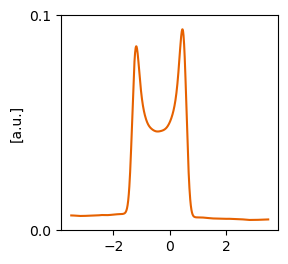

In [92]:
fov = 1000
cross = out_plot[round(Int, size(out_int, 1)/2),
            round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)]
xcross = x2[round(Int, (size(out_int, 2)-fov)/2):round(Int, (size(out_int, 2)+fov)/2)] .* 1e6

cross ./= maximum(cross)
cross .*= cross_max_big

figsize = [7, 7] ./ 2.504

savestring = ("ray_gauss"*string(round(Int, wgauss*1e6))
              *"sep"*string(round(Int, gauss_sep*1e6))
              *"dphi"*string(round(Int, Δφ))*"_cross.svg")

pygui(false)
fig, ax = subplots(figsize=figsize)
ax.plot(xcross, cross, color="#E66100")

ax.set_yticks([0, 0.1])
ax.set_xticks([-2, 0, 2])

#ax.set_xlabel("µm")
ax.set_ylabel("[a.u.]")
savefig("./images/asym/"*savestring, bbox_inches="tight")
;